##### This version of ResNet trains on 20 Epochs first, makes a checkpoint at Epoch 20, and evaluates the model at Epoch 20. After that is done, it will continue training till Epoch 50. This is to showcase the difference between training for 20 Epochs and training for 50 or more Epochs.

##### 1. **Import Libraries**

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import multiprocessing
import os
import random
from PIL import Image
import logging
import cv2
import numpy as np

##### 2. **Set up environment**

In [51]:
# Enable multiprocessing support
multiprocessing.freeze_support()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Set up the device
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")  # For Apple GPUs
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# Define path to dataset
data_dir = '../../dataset_26'

Using device: cpu


##### 3. **Data Preparation & Preprocessing**

In [52]:
def crop_image(image):
    """
    Crop the brain MRI image to focus on the region of interest.
    This function uses contour detection to identify and crop the main brain area.
    """
    try:
        img_array = np.array(image)
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
        img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
        
        _, img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
        img_thresh = cv2.erode(img_thresh, None, iterations=2)
        img_thresh = cv2.dilate(img_thresh, None, iterations=2)

        contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            cropped_image = img_array[y:y+h, x:x+w]
            return Image.fromarray(cropped_image)
        else:
            return image
    except Exception as e:
        logging.error(f"Error in crop_image: {str(e)}")
        return image

class CustomDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for loading and preprocessing brain MRI images.
    Applies different transformations for training and testing data.
    """
    def __init__(self, image_paths, labels, transform=None, is_train=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert('RGB')
            if self.is_train:
                image = crop_image(image)
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            logging.error(f"Error loading image {self.image_paths[idx]}: {str(e)}")
            placeholder_image = torch.zeros((3, 224, 224))
            return placeholder_image, self.labels[idx]

def prepare_data(data_dir, batch_size=32):
    """
    Prepare the data for training, validation, and testing.
    This function:
    1. Defines data transformations
    2. Loads and splits the data into train, validation, and test sets
    3. Creates DataLoader objects for each set
    """
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    class_names = []
    train_data, val_data, test_data = [], [], []

    for class_idx, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_names.append(class_name)
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_paths = []
        for img in os.listdir(class_dir):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    image_paths.append(img_path)
                except Exception as e:
                    logging.error(f"Error processing image {img_path}: {str(e)}")

        random.shuffle(image_paths)

        total = len(image_paths)
        train_split = int(0.7 * total)
        val_split = int(0.2 * total)

        train_data.extend([(img, class_idx) for img in image_paths[:train_split]])
        val_data.extend([(img, class_idx) for img in image_paths[train_split:train_split+val_split]])
        test_data.extend([(img, class_idx) for img in image_paths[train_split+val_split:]])

    train_dataset = CustomDataset([x[0] for x in train_data], [x[1] for x in train_data], transform=train_transform, is_train=True)
    val_dataset = CustomDataset([x[0] for x in val_data], [x[1] for x in val_data], transform=val_test_transform)
    test_dataset = CustomDataset([x[0] for x in test_data], [x[1] for x in test_data], transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, class_names

print("Preparing data...")
batch_size = 32
train_loader, val_loader, test_loader, class_names = prepare_data(data_dir, batch_size)
print("Data preparation completed.")


Preparing data...
Train set size: 336
Validation set size: 96
Test set size: 48
Data preparation completed.


##### 4. **Configure the ResNet Model**

In [53]:
class BrainMRIResNet(nn.Module):
    """
    Define the ResNet model architecture by modifying a pre-trained ResNet50
    """
    def __init__(self, num_classes=4):
        super(BrainMRIResNet, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)
    
    
# Initialize the model
def initialize_model(num_classes, device):
    model = BrainMRIResNet(num_classes=num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    return model, criterion, optimizer, scheduler

##### 5. **Train the Model**

In [54]:
def train_phase(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, start_epoch=0):
    """
    Train and evaluate the model over multiple epochs.
    This function:
    1. Trains the model on the training data
    2. Evaluates the model on validation data
    3. Implements learning rate scheduling
    4. Saves the best model based on validation loss
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    return model, best_model_state, train_losses, val_losses, train_accuracies, val_accuracies

##### 6. **Evaluate Model Performance**

In [55]:
# Evaluate the model on the test set and print performance metrics
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Calculate overall accuracy
    accuracy = (100.0 * sum([1 for p, t in zip(all_preds, all_labels) if p == t])) / len(all_preds)
    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot the training and validation loss and accuracy curves
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(true_labels, predictions, class_names):
    """
    Plot both the regular and normalized confusion matrices.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Create the ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp_norm.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    plt.title('Normalized Confusion Matrix')
    plt.show()

##### 7. **Checkpoint Saving and Loading**

In [56]:
def save_checkpoint(model, optimizer, scheduler, epoch, filename):
    """
    Save model checkpoint
    """
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'epoch': epoch
    }, filename)

def load_checkpoint(model, optimizer, scheduler, filename):
    """
    Load model checkpoint
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch']

##### 8. **Phased Training Execution**

In [57]:
def phase1_training(train_loader, val_loader, test_loader, class_names, device, num_epochs=20):
    """
    Execute Phase 1 of training (initial 20 epochs)
    """
    model, criterion, optimizer, scheduler = initialize_model(len(class_names), device)
    model, best_model_state, train_losses, val_losses, train_accuracies, val_accuracies = train_phase(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )
    save_checkpoint(model, optimizer, scheduler, num_epochs, 'phase1_checkpoint.pth')
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def phase2_training(train_loader, val_loader, test_loader, class_names, device, additional_epochs=30):
    """
    Execute Phase 2 of training (continuing from Phase 1 checkpoint)
    """
    model, criterion, optimizer, scheduler = initialize_model(len(class_names), device)
    start_epoch = load_checkpoint(model, optimizer, scheduler, 'phase1_checkpoint.pth')
    
    total_epochs = start_epoch + additional_epochs
    
    model, best_model_state, train_losses, val_losses, train_accuracies, val_accuracies = train_phase(
        model, train_loader, val_loader, criterion, optimizer, scheduler, 
        num_epochs=total_epochs, 
        device=device,
        start_epoch=start_epoch
    )
    
    save_checkpoint(model, optimizer, scheduler, total_epochs, 'phase2_checkpoint.pth')
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def load_and_evaluate(test_loader, class_names, device, checkpoint_file='phase2_checkpoint.pth'):
    """
    Load a trained model from a checkpoint and evaluate it
    """
    model, criterion, optimizer, scheduler = initialize_model(len(class_names), device)
    load_checkpoint(model, optimizer, scheduler, checkpoint_file)
    evaluate_model(model, test_loader, device, class_names)


##### 9. **Start training and stops at Epoch 20**

In [58]:
# Phase 1: Initial training
print("Starting Phase 1 training...")
model, train_losses1, val_losses1, train_accuracies1, val_accuracies1 = phase1_training(train_loader, val_loader, test_loader, class_names, device)
print("Phase 1 training completed.")

Starting Phase 1 training...
Epoch 1/20, Train Loss: 1.1927, Train Acc: 46.13%, Val Loss: 1.8939, Val Acc: 30.21%
Epoch 2/20, Train Loss: 0.7772, Train Acc: 69.94%, Val Loss: 1.5870, Val Acc: 62.50%
Epoch 3/20, Train Loss: 0.6834, Train Acc: 74.40%, Val Loss: 3.5481, Val Acc: 44.79%
Epoch 4/20, Train Loss: 0.7931, Train Acc: 73.51%, Val Loss: 1.2185, Val Acc: 57.29%
Epoch 5/20, Train Loss: 0.6197, Train Acc: 79.17%, Val Loss: 1.7163, Val Acc: 44.79%
Epoch 6/20, Train Loss: 0.7300, Train Acc: 72.62%, Val Loss: 0.9479, Val Acc: 73.96%
Epoch 7/20, Train Loss: 0.6792, Train Acc: 73.81%, Val Loss: 1.2482, Val Acc: 60.42%
Epoch 8/20, Train Loss: 0.5938, Train Acc: 75.00%, Val Loss: 0.5287, Val Acc: 82.29%
Epoch 9/20, Train Loss: 0.5651, Train Acc: 76.79%, Val Loss: 0.9289, Val Acc: 61.46%
Epoch 10/20, Train Loss: 0.5590, Train Acc: 76.19%, Val Loss: 0.6554, Val Acc: 78.12%
Epoch 11/20, Train Loss: 0.4903, Train Acc: 82.44%, Val Loss: 0.9492, Val Acc: 58.33%
Epoch 12/20, Train Loss: 0.4993, T

##### 10. **Evaluation for 20 Epochs**

Evaluating model after Phase 1...

Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    1.0000    1.0000        12
  meningioma     0.9000    0.7500    0.8182        12
     notumor     0.8000    1.0000    0.8889        12
   pituitary     1.0000    0.9167    0.9565        12

    accuracy                         0.9167        48
   macro avg     0.9250    0.9167    0.9159        48
weighted avg     0.9250    0.9167    0.9159        48


Overall Accuracy: 91.67%


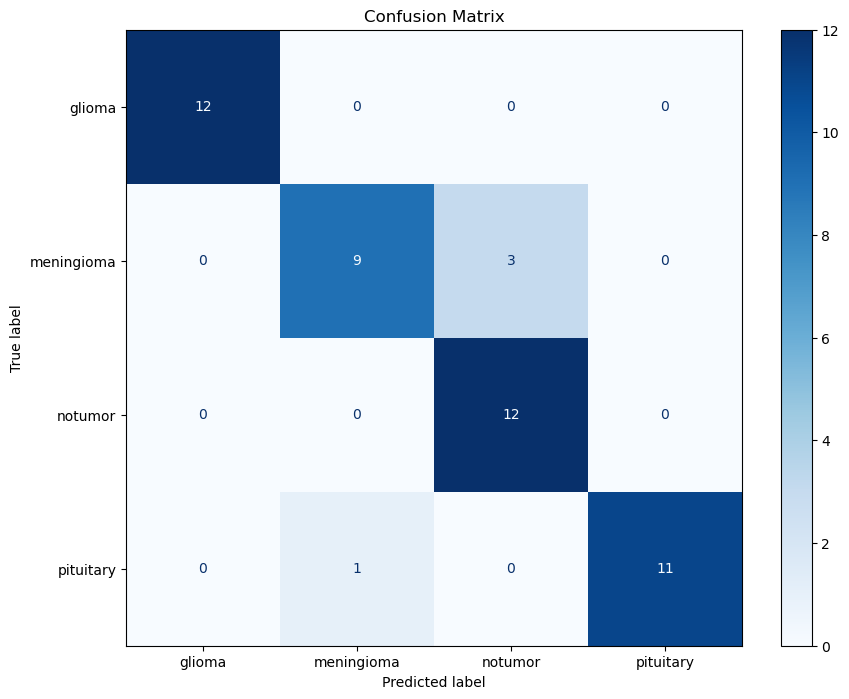

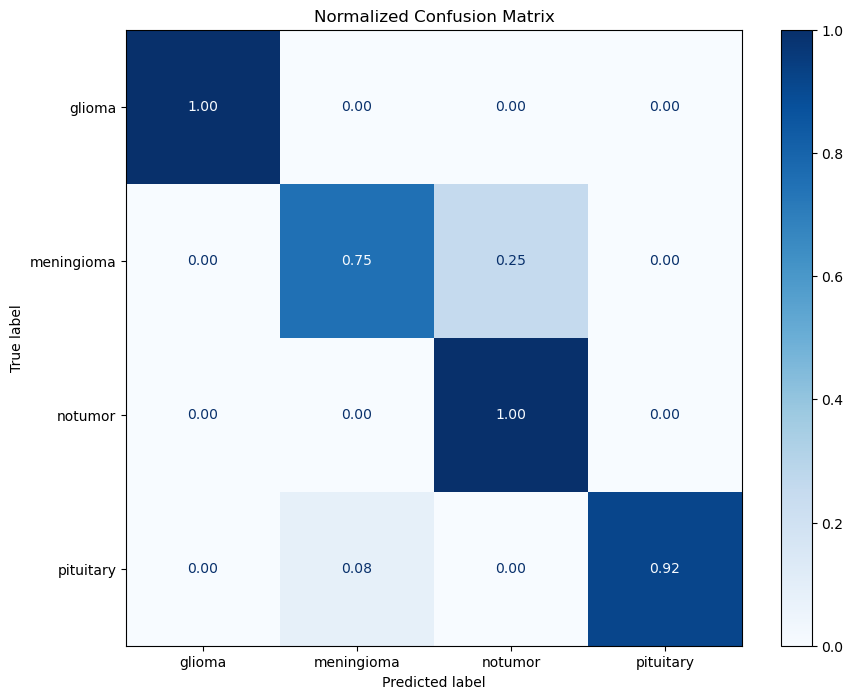

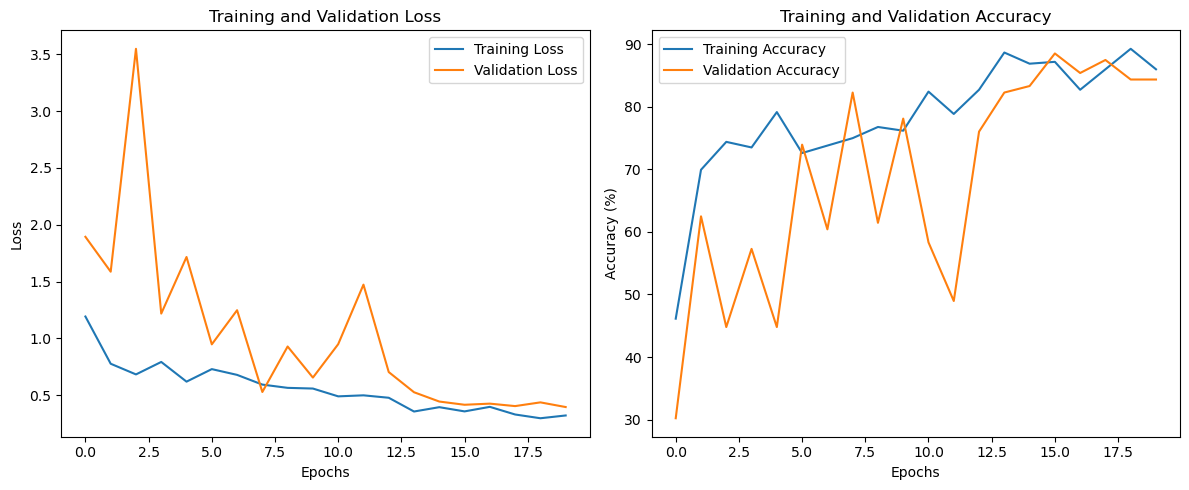

In [59]:
# Evaluate after Phase 1
print("Evaluating model after Phase 1...")
load_and_evaluate(test_loader, class_names, device, 'phase1_checkpoint.pth')
plot_training_history(train_losses1, val_losses1, train_accuracies1, val_accuracies1)

##### 11. **Continue training**

In [60]:
# Phase 2: Continue training
print("Starting Phase 2 training...")
model, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = phase2_training(train_loader, val_loader, test_loader, class_names, device)
print("Phase 2 training completed.")

Starting Phase 2 training...
Epoch 21/50, Train Loss: 0.3589, Train Acc: 85.71%, Val Loss: 0.3994, Val Acc: 85.42%
Epoch 22/50, Train Loss: 0.3200, Train Acc: 86.90%, Val Loss: 0.4012, Val Acc: 87.50%
Epoch 23/50, Train Loss: 0.2819, Train Acc: 89.58%, Val Loss: 0.3961, Val Acc: 88.54%
Epoch 24/50, Train Loss: 0.3338, Train Acc: 90.48%, Val Loss: 0.4560, Val Acc: 82.29%
Epoch 25/50, Train Loss: 0.3018, Train Acc: 87.80%, Val Loss: 0.6042, Val Acc: 75.00%
Epoch 26/50, Train Loss: 0.2649, Train Acc: 91.67%, Val Loss: 0.4341, Val Acc: 84.38%
Epoch 27/50, Train Loss: 0.3108, Train Acc: 87.20%, Val Loss: 0.4500, Val Acc: 81.25%
Epoch 28/50, Train Loss: 0.2930, Train Acc: 90.18%, Val Loss: 0.4457, Val Acc: 82.29%
Epoch 29/50, Train Loss: 0.2609, Train Acc: 88.99%, Val Loss: 0.4505, Val Acc: 81.25%
Epoch 30/50, Train Loss: 0.2715, Train Acc: 89.88%, Val Loss: 0.4491, Val Acc: 81.25%
Epoch 31/50, Train Loss: 0.2939, Train Acc: 88.69%, Val Loss: 0.4486, Val Acc: 81.25%
Epoch 32/50, Train Loss: 

##### 12. **Evaluation for all epochs**

Plotting combined training history...


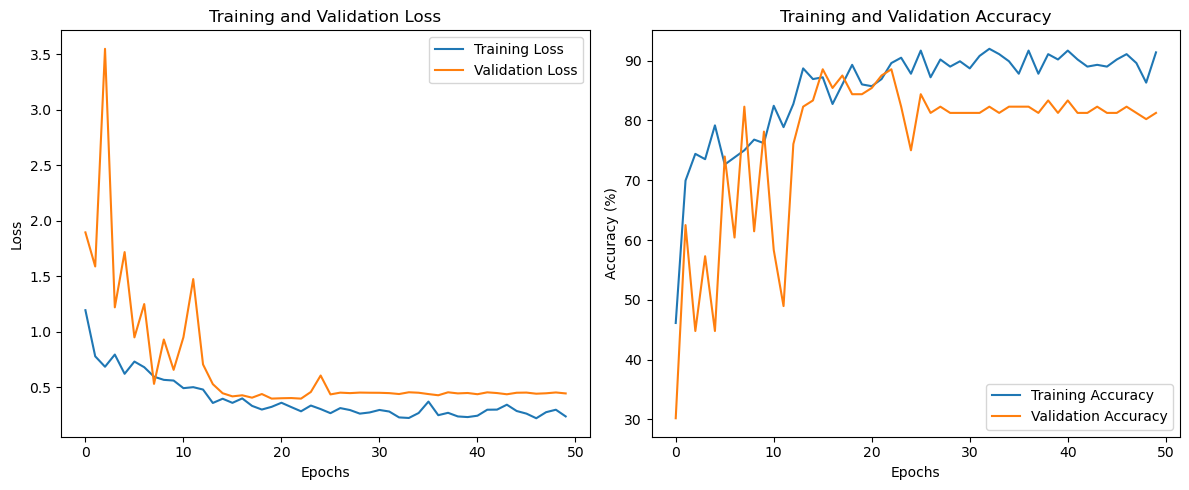

Evaluating model cumulatively after both phases...

Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    0.7500    0.8571        12
  meningioma     0.7143    0.8333    0.7692        12
     notumor     0.8000    1.0000    0.8889        12
   pituitary     1.0000    0.8333    0.9091        12

    accuracy                         0.8542        48
   macro avg     0.8786    0.8542    0.8561        48
weighted avg     0.8786    0.8542    0.8561        48


Overall Accuracy: 85.42%


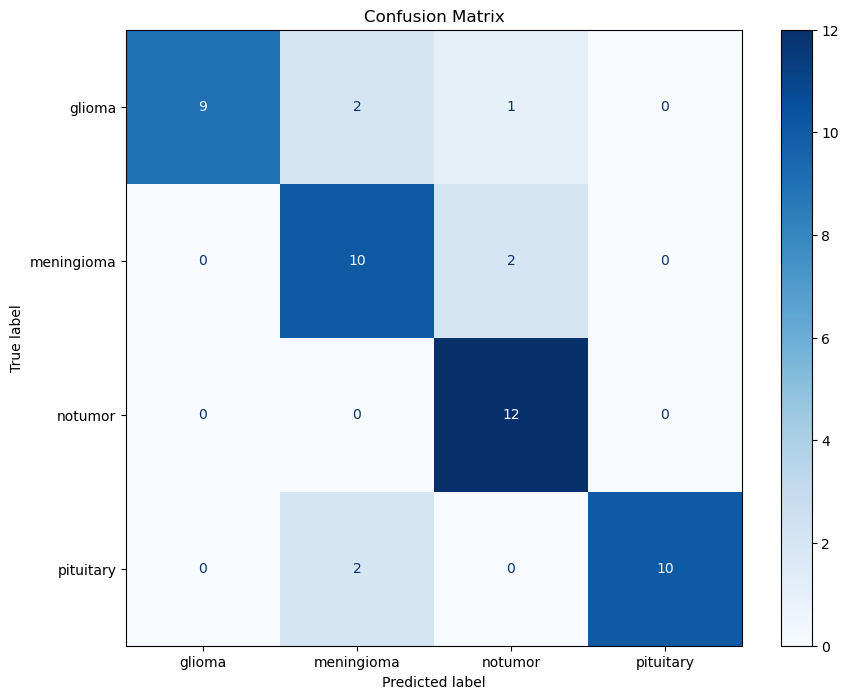

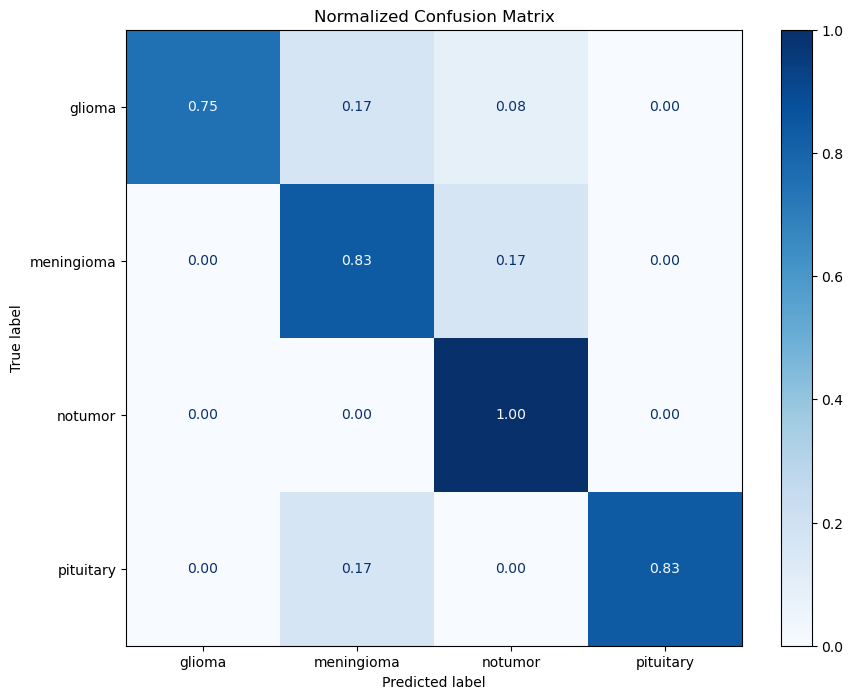

Cumulative training and evaluation completed.


In [63]:
# Combine results from both phases
combined_train_losses = train_losses1 + train_losses2
combined_val_losses = val_losses1 + val_losses2
combined_train_accuracies = train_accuracies1 + train_accuracies2
combined_val_accuracies = val_accuracies1 + val_accuracies2

# Plot combined training history
print("Plotting combined training history...")
plot_training_history(combined_train_losses, combined_val_losses, combined_train_accuracies, combined_val_accuracies)

# Evaluate cumulatively after both phases
print("Evaluating model cumulatively after both phases...")
load_and_evaluate(test_loader, class_names, device, 'phase2_checkpoint.pth')

print("Cumulative training and evaluation completed.")

##### 13. **Plot combined training history**

Plotting combined training history...


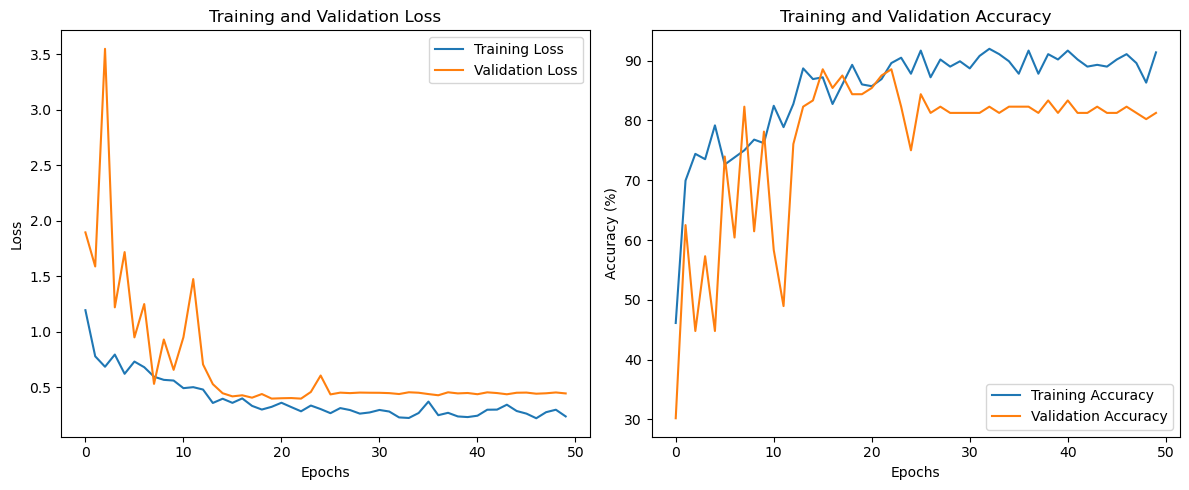

Training and evaluation completed.


In [62]:
# Optionally, plot combined training history
print("Plotting combined training history...")
combined_train_losses = train_losses1 + train_losses2
combined_val_losses = val_losses1 + val_losses2
combined_train_accuracies = train_accuracies1 + train_accuracies2
combined_val_accuracies = val_accuracies1 + val_accuracies2
plot_training_history(combined_train_losses, combined_val_losses, combined_train_accuracies, combined_val_accuracies)

print("Training and evaluation completed.")